# Make Figures for Model Validation: Formation Cycles

5/9/2023

Andrew Weng

In [9]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

from src import cellsim as cellsim 

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from src import plotter as plotter

%load_ext autoreload

plotter.initialize(plt, style='ieee')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Run the simulation

In [10]:
%autoreload 
Ichg = 2.5/10  # A
Idch = -2.5/10 # A
Icv = 2.5/20   # A

vmax = 4.2
vmin = 3.0

cell = cellsim.Cell()
cell.load_config('params/default.yaml')
tag = cell.get_tag()

# sim = cellsim.Simulation(cell, 520*3600)
sim = cellsim.Simulation(cell, 70*3600)

# Formation
sim.run_rest(1, rest_time_hrs=0.5)
sim.run_chg_cccv(2, 2.5/10, Icv, vmax)
sim.run_dch_cccv(2, Idch, Idch, vmin)
sim.run_chg_cccv(3, 2.5/10, Icv, vmax)
sim.run_dch_cccv(3, Idch, Idch, vmin)
sim.run_chg_cccv(4, 2.5/10, Icv, vmax)
sim.run_dch_cccv(4, Idch, Idch, vmin)

df_sim = sim.get_results()

Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...
Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...


/Users/aweng/code/formation-modeling/src/cellsim.py:560: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  bbox_inches='tight', dpi=200)
/Users/aweng/code/formation-modeling/src/cellsim.py:678: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  dpi=200)


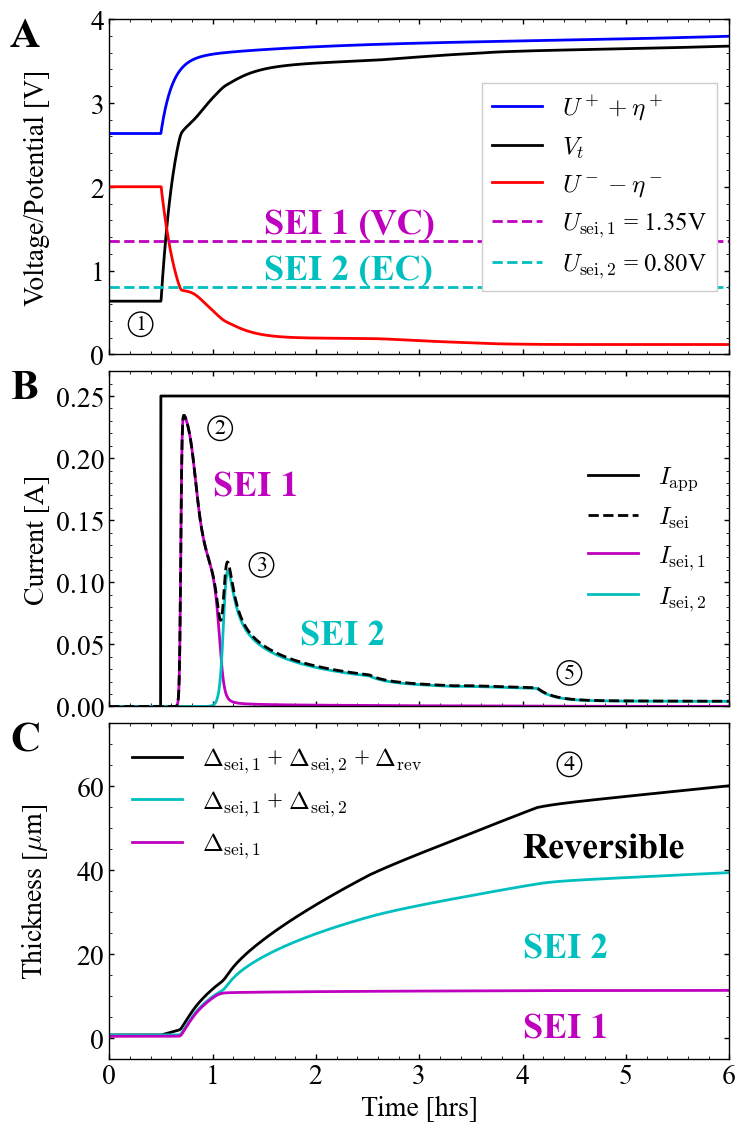

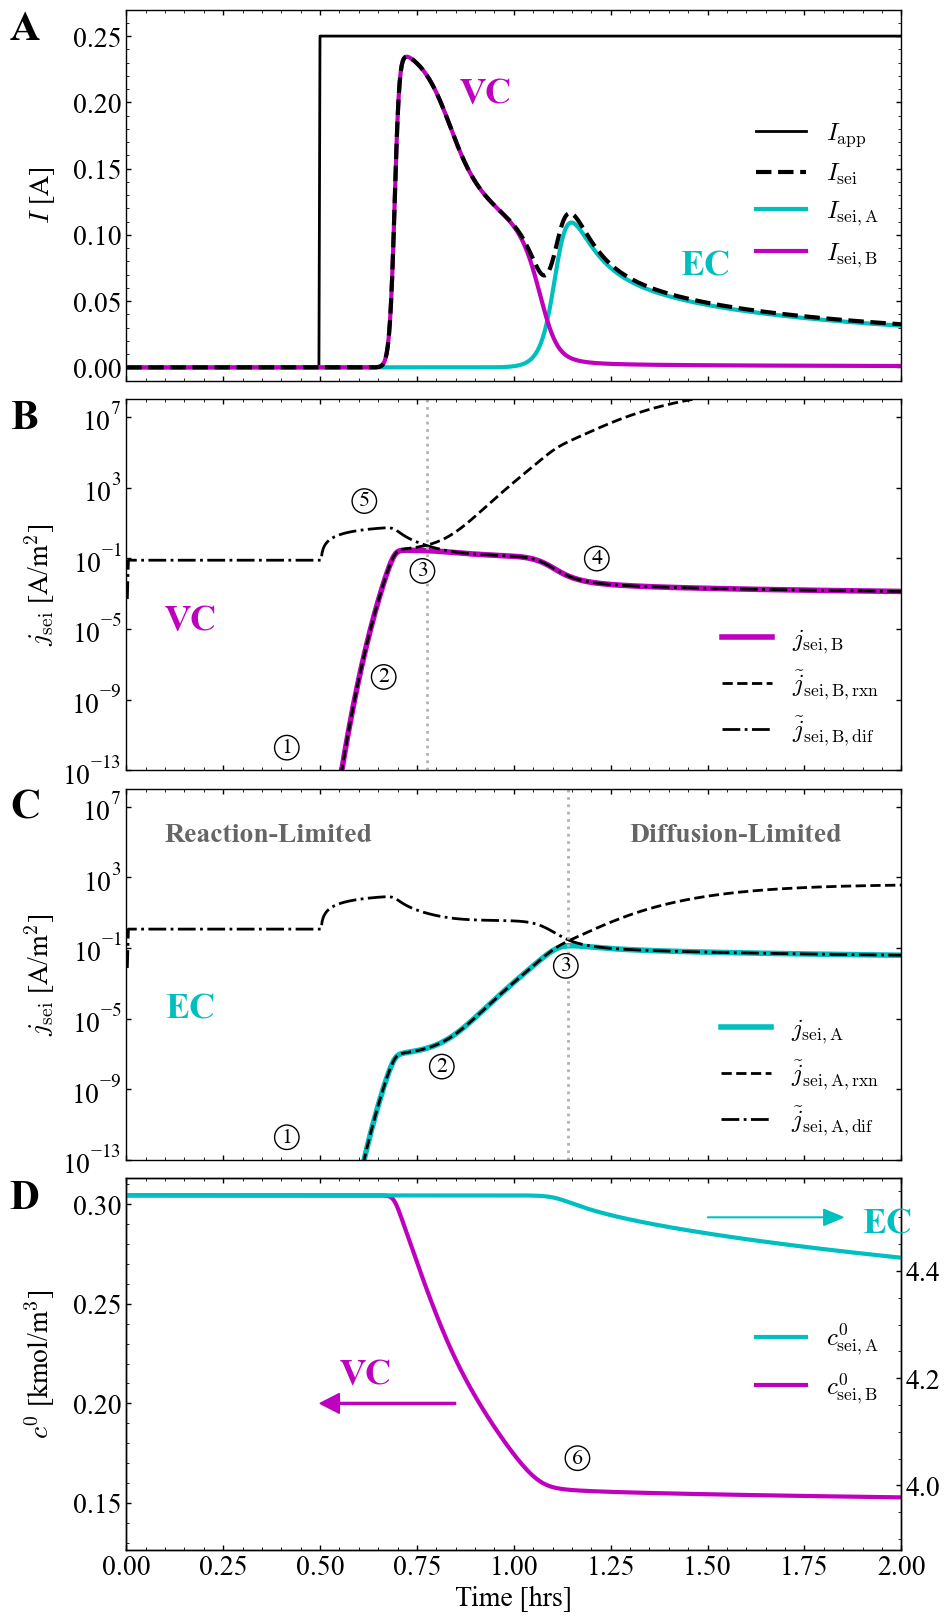

In [29]:
%autoreload
sim.plot_view_1(xlims=(0, 6), to_save=True)

In [12]:

df_agg = df_sim.groupby(['cycle_number', 'step_number'])['dq'].agg('sum')
df_min = df_sim.groupby(['cycle_number'])['theta_n'].agg('min')
df_max = df_sim.groupby(['cycle_number'])['theta_p'].agg('max')

print(df_agg)
ce_sim = []
qc_sim = []
qd_sim = []
theta_p0_sim = []
theta_n0_sim = []
cycle_index = np.array([2, 3, 4])
for i in cycle_index:
    qd_sim.append(df_agg[i][2])
    qc_sim.append(df_agg[i][0] + df_agg[i][1])
    ce_sim.append(df_agg[i][2] / (df_agg[i][0] + df_agg[i][1]))
    theta_p0_sim.append(df_max[i])
    theta_n0_sim.append(df_min[i])

ce_sim = np.array(ce_sim)
qc_sim = np.array(qc_sim)
qd_sim = np.array(qd_sim)
theta_p0_sim = np.array(theta_p0_sim)
theta_n0_sim = np.array(theta_n0_sim)

cycle_number  step_number
1.0           4.0            0.000000
2.0           0.0            2.908333
              1.0            0.004936
              2.0            2.629167
3.0           0.0            2.624306
              1.0            0.005055
              2.0            2.569444
4.0           0.0            2.564583
              1.0            0.005015
              2.0            2.525000
Name: dq, dtype: float64
